# BAT TTE Imaging Analysis Overview

## This notebook gives a brief overview of the capabilities of the BatAnalysis package to dynamically analyze BAT Time-tagged Event (TTE) data as it relates to the imaging capabilities of BAT. 

## Installation instructions for Beta testers:

Thanks to all who are willing to test the TTE portion of BatAnalysis. Here are some quick instructions for getting the code and installing it for access in python:
- `git clone -b TTE_analysis https://github.com/parsotat/BatAnalysis.git`
- `cd BatAnalysis`
- if BatAnalysis is already installed: `pip uninstall BatAnalysis`
- `pip install -e .`

Then in a jupyter notebook or an ipython session `import batanalysis as ba` should work.

Any issues that get brought up will be pushed to the github branch. To get these changes simply do `git pull` in the BatAnalysis directory and the next time you do `import batanalysis as ba` the changes will be implemented.

Here, we will analyze a BAT triggered GRB to exhibit the various capabilities that the BatAnalysis tool offers to interact with the TTE data, allowing users to download data, create sky images at any arbitrary time bin with any energy binning. 

Once again, we will look at GRB 211211A, a bright long GRB that was determined to be from a merger of compact objects. This GRB was detected by BAT and the refined analyses can be found here: https://swift.gsfc.nasa.gov/results/batgrbcat/GRB211211A/web/GRB211211A.html

Lets start off by importing the necessary python packages. 

In [1]:
import batanalysis as ba
from swifttools.swift_too import ObsQuery 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

### 1. Download the data

First, lets download the BAT TTE data for this event. We will use the basics of downloading Swift BAT data covered in the **Example_data_download** notebook in this directory. 

We will use the swifttools package to query over the hour that the GRB has occured to get the observations that have occured. We expect the GRB to appear here since we know that the GRB occured on 2021-12-11 with the trigger time of 13:09:59.634260 UTC. 

Documentation for swifttools can be found here: https://www.swift.psu.edu/too_api/

If you recently ran the **Example_TTE_rate_data_analysis** notebook in this directory then this directory will still exist and nothing will actually be downloaded.


In [2]:
tstart=Time("2021-12-11T13:00:00")
tend=Time("2021-12-11T14:00:00")

obs_table=ObsQuery(begin=tstart, end=tend)
print(obs_table)

+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
|          Begin Time |            End Time |          Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+----------------------+--------------------+--------------+--------------+
| 2021-12-11 12:57:02 | 2021-12-11 13:10:36 |              Mrk 279 |        00037591121 |          685 |          129 |
| 2021-12-11 13:10:37 | 2021-12-11 13:15:21 |          GRB 211211A |        01088940000 |          215 |           69 |
| 2021-12-11 13:15:26 | 2021-12-11 13:28:00 |        CYGNUSCOCOON2 |        00095933007 |          630 |          124 |
| 2021-12-11 13:28:02 | 2021-12-11 13:52:57 | XMM_J004855.5-734946 |        00034599017 |         1310 |          185 |
| 2021-12-11 13:53:02 | 2021-12-11 13:57:59 |           SN2021aefx |        00014916016 |          235 |           62 |
| 2021-12-11 13:58:03 | 2021-12-11 14:06

Lets programatically select this observation and download all the data in the bat and auxil directories to a temporary directory. 

In [3]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

grb_obs=[i for i in obs_table if "GRB" in i.targname]
download = ba.download_swiftdata(grb_obs, quiet=False)

datadir=ba.datadir().joinpath(grb_obs[0].obsid)

print(download)
print(ba.datadir())

{'01088940000': {'obsid': '01088940000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/01088940000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='01088940000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}
/private/tmp/batdata/download_examples


/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: SWIFT_TLE_ARCHIVE.txt.21353.74897066.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw01088940000pat.fits.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw01088940000pjb.par.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw01088940000pob.cat.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/swifttools/swift_too/swift_data.py:405: UserWarning: sw01088940000ppr

Lets take a look at the files that we have downloaded. 

In [4]:
download[grb_obs[0].obsid]["data"]

01088940000/auxil,SWIFT_TLE_ARCHIVE.txt.21353.74897066.gz,Auxillary TLE file
'',sw01088940000pat.fits.gz,Auxillary attitude file
'',sw01088940000pjb.par.gz,Auxillary file
'',sw01088940000pob.cat.gz,Auxillary catalog
'',sw01088940000ppr.par.gz,Auxillary file
'',sw01088940000s.mkf.gz,Auxillary file
'',sw01088940000sao.fits.gz,Auxillary file
'',sw01088940000sat.fits.gz,Auxillary attitude file
'',sw01088940000sen.hk.gz,Auxillary housekeeping
'',sw01088940000sti.fits.gz,Auxillary file
'',sw01088940000uat.fits.gz,Auxillary attitude file


As is shown above, we have: 
 - the auxil directory with information related to the spacecraft, 
 - the tdrss directory with information related to the tdrss downlinked information for the GRB when it triggered BAT, 
 - the rate directory which holds hardware rate information, 
 - the event directory with the TTE data
 - the housekeeping directory with information related to the BAT instrument itself
 - the masktag directory with the Swift Data Center (SDC) precomputed coded mask weights for the GRB
 - the products directory with SDC precomputed lightcurves at various time/energy binnings, pha files at predetermined timebins, and sky images
 - the survey directory which holds BAT survey data associated with this observation, which can be analyzed following the **Example_Survey_Data_Analysis** notebook
 
 In this notebook, we will focus on the imaging capability and better understand how we can interact with and reproduce the precomputed detector plane histograms (DPHs), the Detector Plane Images (DPIs), and sky image files from the SDC, and how we can construct new sky image files and access the relevant data. We will additionally delve into mosaicing (adding these images) and source detection. 

### 2. Loading the precomputed Detector Plane Histograms (DPHs)

The DPHs are not an integral part of imaging analyses with BAT, however they provide a useful introduction to ways that we will interact with the other BAT data products. 

DPHs are simply histograms of the TTE data binned in space (by detector) and time. The BatAnalysis class that handles this is called `BatDPH` which inherits many properties from the `Histogram` class that is available through the [histpy](https://histpy.readthedocs.io/en/latest/tutorials/quick-start.html#) python package. 

***NOTE: The DPH and Detector Plane Images include locations where there are no actual detector pixels in the detector plane.***

There are many intuitive things that we can do with this BatDPH object. To show some of these aspect, lets start by first loading in a precomputed DPH from the data that we have downloaded for GRB 211211A. To do this we simply use the `from_file` class method. 

In [5]:
dph=ba.BatDPH.from_file(datadir.joinpath("bat/survey").joinpath("sw01088940000bsvabo27acg0859.dph.gz"))

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_dph.py:198: UserWarning: No event file has been specified. The resulting DPH object will not be able to be arbitrarily modified either by rebinning in energy or time.


We can easily plot the DPH to take a look at it:

(<Figure size 640x480 with 2 Axes>, <Axes: >)

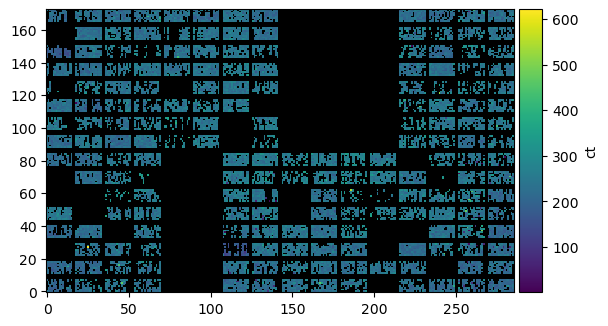

In [6]:
dph.plot()

We can see that we have lots of detectors that are off, as is shown in black, while the other detectors that are on have registered a few hundred counts over some amount of time and over some amount of energy. To find out what the timebins and energy bins are for the histogramming that was done here we can access the `.tbins` and `.ebins` attributes. 

In [7]:
print(dph.tbins)
print(dph.ebins)

{'TIME_START': <Quantity [6.60921451e+08, 6.60921751e+08, 6.60922051e+08] s>, 'TIME_STOP': <Quantity [6.60921751e+08, 6.60922051e+08, 6.60922083e+08] s>, 'TIME_CENT': <Quantity [6.60921601e+08, 6.60921901e+08, 6.60922067e+08] s>}
{'INDEX': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), 'E_MIN': <Quantity [  0. ,  10. ,  12. ,  14. ,  16. ,  18. ,  20. ,  22. ,  24. ,
            26. ,  28. ,  30.1,  32.1,  34.2,  36.3,  38.3,  40.4,  42.5,
            44.6,  46.8,  48.9,  51.1,  53.2,  55.4,  57.6,  59.8,  62. ,
            64.2,  66.4,  68.7,  70.9,  73.2,  75.4,  77.7,  80. ,  82.3,
            84.6,  87. ,  89.3,  91.7,  94. ,  96.4,  98.8, 101.2, 103.6,
           106. , 108.4,

We can see that we have 3 timebins and 80 energy channels for this DPH. When we plotted the DPH, we projected the histogram onto it's spatial axis and added all the counts for each detector in each time and energy bin. If we want, we can plot a single energybin and a single timebin to see how the DPH changes.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

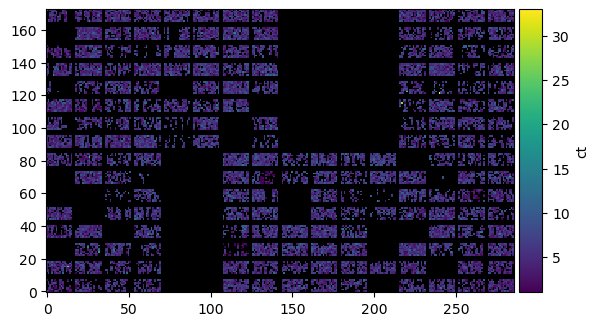

In [8]:
dph.plot(emin=14*u.keV, emax=16*u.keV, tmin=dph.tbins["TIME_START"][0], tmax=dph.tbins["TIME_STOP"][0])

We can see that the counts have significantly changed for the single energy range and time range that we are plotting. To better understand the layout of the BatDPH object, we can access the axes and print out the number of bins that we have:

In [9]:
print(dph.axes.labels)
print(dph.nbins)

['TIME' 'DETY' 'DETX' 'ENERGY']
[  3 173 286  80]


We can see that the 2 spatial dimensions are related to the detector X/Y coordinates, while everything else is temporal or energy binning related. 

### 3. Running the traditional batanalysis pipeline so we can verify our results

Here, we will run batgrbproducts on the directory so we have a set of precomputed Detector Plane Images and sky images that we can interact with, to show the various capabilities of the BatAnalysis Tools, and attempt to reproduce these results, to verify the results of the BatAnalysis Tools and show how we can use the package to conduct imaging analyses of BAT TTE data. 

In [10]:
import heasoftpy as hsp
batgrbproduct_result_dir=datadir.parent.joinpath(f"{datadir.stem}-batgrbproduct-result")
hsp.batgrbproduct(indir=datadir, outdir=batgrbproduct_result_dir)

---------------------
:: Execution Result ::
---------------------
> Return Code: 0
> Output:
 ============= batgrbproduct v2.48 ================= 
# Environment variable check
# Importing external modules
Reading default configuration...
PARAMETER VALUES
  indir=/private/tmp/batdata/download_examples/01088940000
  outdir=/private/tmp/batdata/download_examples/01088940000-batgrbproduct-result
  ra=BAT
  dec=BAT
  trigtime=0
  trigstop=0
  backstrt=0
  backstop=0
  date_obs=INDEF
  extractor=fextract-events
  aperture=CALDB:FLUX
  pcodethresh=0 imgpcodethresh=0.05
  shortfix=scaledmap,expand
  tnear=2000
  tbinmax=1000
# Reading input parameters
     root=/private/tmp/batdata/download_examples/01088940000 outdir=/private/tmp/batdata/download_examples/01088940000-batgrbproduct-result
Reading target ID...
     TARG_ID='01088940'
events=/private/tmp/batdata/download_examples/01088940000/bat/event/sw01088940000bevshsp_uf.evt.gz
Making output directories
Finding attitude files
     attitude=

As we can see from the cell output, there are many default files that are produced. We have dealt with the lightcurves and the pha files in the ***Example_TTE_rate_data_analysis*** jupyter notebook. Here we will focus on the detector plane images and the sky images. 

### 4. Loading in a Precomputed Detector Plane Image (DPI)

A DPI is the same as a DPH for the case of TTE data, where the data has had the proper energy calibration applied to it. This is automatically taken care of in the batgrbproducts pipeline and the BatAnalysis Tools' BatEvent class that deals with this type of BAT data. As a result, eveything that we showed in the DPH section of the notebook applies here for DPIs, except that we use the BatDPI class to handle this type of data.

To show this we will load in a precomputed DPI file from when the GRB was initially detected, the pre-slew file where the name indicates that the time binning corresponds to the time before Swift started slewing to the location of the GRB. 

In [11]:
preslew_dpi=ba.BatDPI.from_file(batgrbproduct_result_dir.joinpath("dpi").joinpath("sw01088940000b_preslew_4chan.dpi"))
print(preslew_dpi.tbins, preslew_dpi.exposure)
print(preslew_dpi.ebins)

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_dpi.py:203: UserWarning: No event file has been specified. The resulting DPI object will not be able to be arbitrarily modified either by rebinning in energy or time.


{'TIME_START': <Quantity [6.60921028e+08] s>, 'TIME_STOP': <Quantity [6.60921037e+08] s>, 'TIME_CENT': <Quantity [6.60921032e+08] s>} [8.83258998] s
{'INDEX': array([1, 2, 3, 4]), 'E_MIN': <Quantity [ 15.,  25.,  50., 100.] keV>, 'E_MAX': <Quantity [ 25.,  50., 100., 350.] keV>}


We can plot the DPI projected over the energy bins, similar to what was done in the DPH section. We still see that there are large chunks of detectors that are turned off, but we also see the detectors that were illimunated by the GRB. This GRB had a partial coding of $\sim 22\%$ and we can see that this is the approximate portion of the detector plane that is illuminated. 

(<Figure size 640x480 with 2 Axes>, <Axes: >)

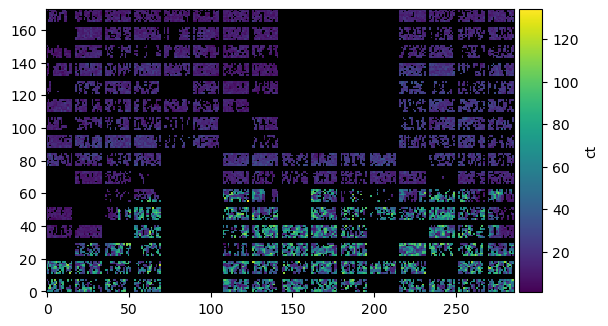

In [12]:
preslew_dpi.plot()

Lets take a look at the BatDPI object. Identical to the DPH that we saw earlier, we've got 4 axes for "TIME", "DETX", "DETY", and "ENERGY". These allow different operations to be completed for them from [slicing](https://histpy.readthedocs.io/en/latest/tutorials/quick-start.html#Slice-and-project) over different axes to [projecting](https://histpy.readthedocs.io/en/latest/tutorials/quick-start.html#Slice-and-project) over them to get rid of the axis (for example integrating over time or over the DETX values)

In [13]:
print(preslew_dpi.axes.labels)

['TIME' 'DETY' 'DETX' 'ENERGY']


If we were interested in the counts that we have from the 0,0th pixel, we can use the properties of the histogram class. Here we project the DPI onto the "DETX","DETY" & "ENERGY" axes and get rid of the "TIME" axis, since we dont care about this. Then we take a slice of the histogram correspondent to the DETX=0, DETY=0 pixel, selecting all energy bins, and finally get rid of the "DETX" & "DETY" axes with the final projection onto the "ENERGY" axis. We can see what the course photon count spectrum looks like for the pixel of interest by plotting it.

(<Axes: xlabel='ENERGY [keV]', ylabel='[ct]'>,
 <ErrorbarContainer object of 3 artists>)

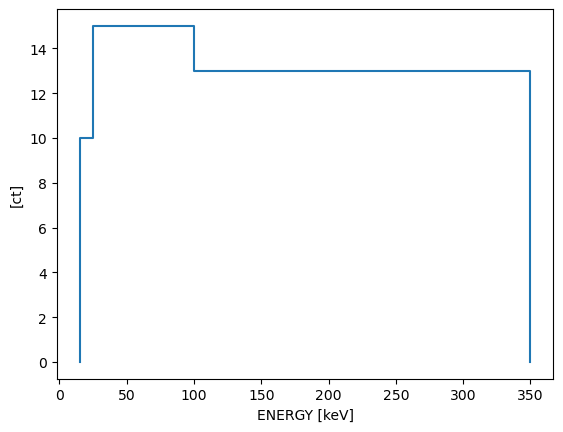

In [14]:
preslew_dpi.project("DETX","DETY","ENERGY").slice[0,0,:].project("ENERGY").plot()

We can even rebin the DPI in energy if we would like. 

***NOTE: with DPIs that are loaded in from a preconstructed DPI file it is not possible to undo any energy or time binning. To get back to the original binning, the file will need to be reloaded***

In [32]:
preslew_dpi.set_energybins(emin=100*u.keV, emax=350*u.keV)
print(preslew_dpi.ebins)
preslew_dpi.plot()

ValueError: The DPH either has  no energy information or there is only one energy bin which means thatthe DPH cannot be rebinned in energy.

DPIs are a necessary data product to eventually produce sky images for BAT which we will touch on next. 

### 5. Loading in Precomputed BAT Sky Images

The Swift Data Center and the batgrbproducts pipelines both produce sky images by default. Lets look at one of these sky images to get a feel for manipulating them. The preslew DPI that we looked at in the prior section has an associated sky image (in 1 energy bin) which we will load into a BatSkyView object to understand how we can manipulate this data. 

In [16]:
preslew_skyview=ba.BatSkyView.from_file(batgrbproduct_result_dir.joinpath("img").joinpath("sw01088940000b_preslew_1chan.img"))

Lets first plot the sky image. In order to do this, we access the flux sky image that we just created using the `.` notation. Then we can easily plot the flux sky image. If you look carefully, you can see the pixel that the GRB is located within in the top left of the plot. 

/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.


(<Axes: xlabel='IMX', ylabel='IMY'>,
 <matplotlib.collections.QuadMesh at 0x1277d8290>)

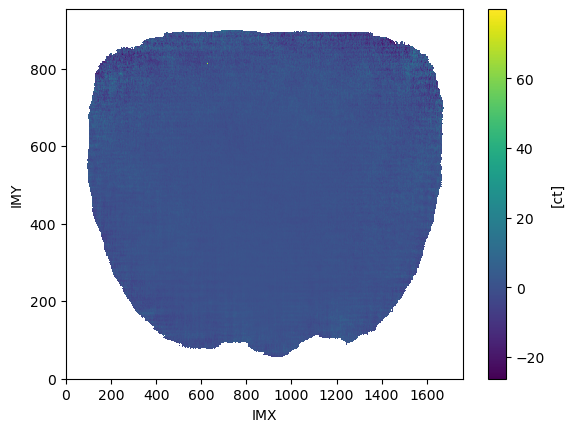

In [18]:
preslew_skyview.sky_img.plot()

We can also take a look at the flux sky image's energy bin to see how it differs from the 4 channel DPI with a similar name. This flux sky image was constructed in a single 15-350 keV energy range. 

In [19]:
print(preslew_skyview.sky_img.ebins)

{'INDEX': array([1]), 'E_MIN': <Quantity [15.] keV>, 'E_MAX': <Quantity [350.] keV>}


This skyview object is more than an image, since it can contain many peices of information about BAT's view of the sky at a single timebin. One bit of information that it can hold for us is the partial coding image, which is currently not initalized in the SkyView. To do so we simply set the `pcodeimg_file` attribute to the precomputed partial coding image from batgrbproducts: 

In [20]:
preslew_skyview.pcodeimg_file=batgrbproduct_result_dir.joinpath("img").joinpath("sw01088940000b_preslew.pcodeimg")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59559.546100 from DATE-OBS.
Set MJD-END to 59559.560012 from DATE-END'. [astropy.wcs.wcs]


Now we can plot it to see what it looks like:

/Users/tparsota/opt/anaconda3/envs/py311/lib/python3.11/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.


(<Axes: xlabel='IMX', ylabel='IMY'>,
 <matplotlib.collections.QuadMesh at 0x16b1e0290>)

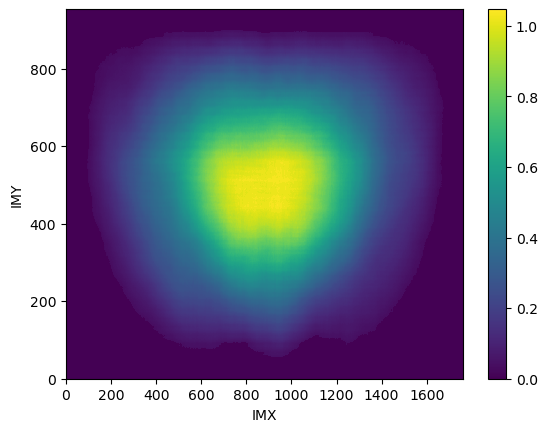

In [21]:
preslew_skyview.pcode_img.plot()

Now the BatSkyView object has information related to the sky flux and the partial coding, however it can also hold images related to the background standard deviation and the SNR (which we will cover later on as these images are not constructed by default in batgrbproducts.)

Additionally, these sky images are in image coordinates which are not very intuitive. We can plot the sky flux image in a ra/dec coordinate projction or even a healpix projection (in galactic or icrs coordinate systems) using the convenience plotting method associated with the flux sky image of the partial coding image. This conveiently shows the BAT's FOV at a given point in time. 

(<Figure size 640x480 with 2 Axes>, <WCSAxes: >)

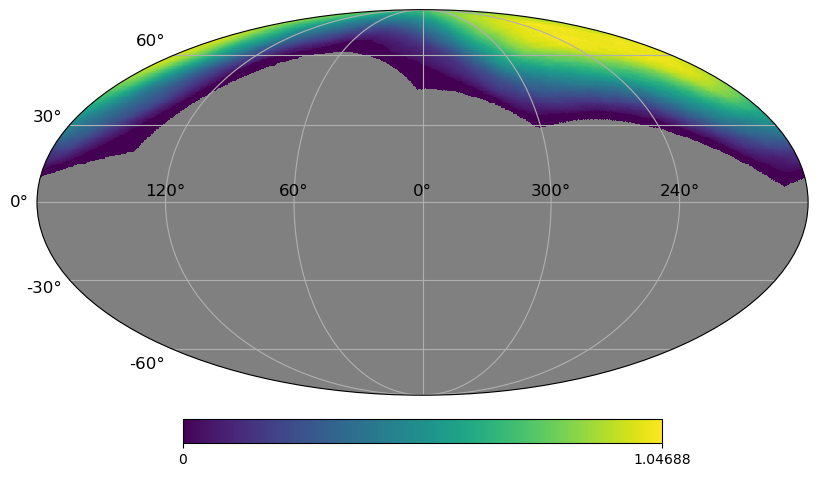

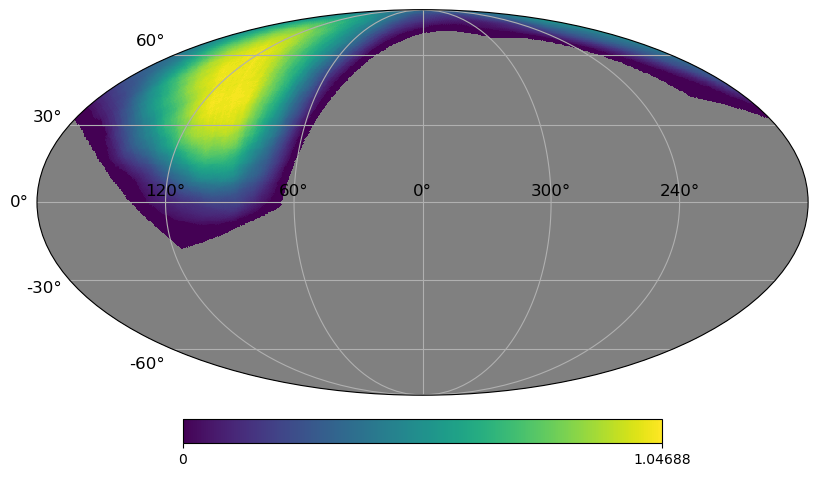

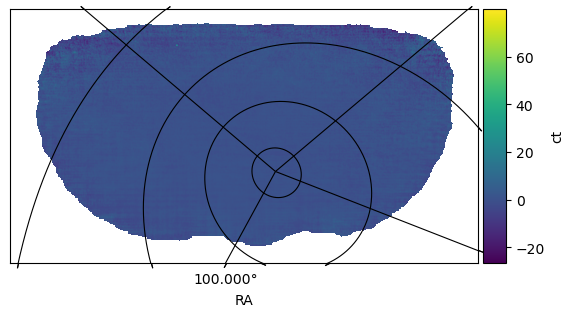

In [25]:
preslew_skyview.pcode_img.plot(projection="healpix", coordsys="icrs")
preslew_skyview.pcode_img.plot(projection="healpix", coordsys="galactic")
preslew_skyview.sky_img.plot(projection="ra/dec")

### 6. Creating Custom DPIs and SkyViews

In this section we will recreate the DPI and the SkyView that were precomputed before to verify that the pipeline works as intended. In the next section will also show how the BatAnalysis software expands on the imaging analysis that was previously possible with source detection and mosaicing. 

Our first step is to initalize the event data with a BatEvent object, similar to what we did in Section 4 of the Example_TTE_rate_data_analysis jupyter notebook.

In [33]:
event=ba.BatEvent(grb_obs[0].obsid)

A save file has been written to /private/tmp/batdata/download_examples/01088940000_eventresult/batevent.pickle.


To create a DPI, we can simply access the `create_DPI` method. To get information/documentation on this method we can do:

In [34]:
event.create_dpi?

We can see that we can pass in the timebin edges as well as the energybin edges. Lets get the preslew DPI information and use that to create our own DPI. Since we rebinned the preslew_dpi above, we have just entered the energy bin edges that we want.

In [45]:
preslew_timebins=u.Quantity([preslew_dpi.tbins["TIME_START"][0], preslew_dpi.tbins["TIME_STOP"][0]])

In [46]:
preslew_energybins=[ 15.,  25.,  50., 100., 350]*u.keV

In [47]:
event_dpi=event.create_dpi(timebins=preslew_timebins, energybins=preslew_energybins)

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'